### Assuming user intend to interact with IRT via following 3 schemes:
**Scheme 1.** Using all available defaults.

**Scheme 2.** Changing some values and passing new vals to model params.

**Scheme 3.** User bringing in all initializer objects nad passing corresponding object declarations to model_params.

#### Building onto saved dataframe,  following  function appends/extends new records to existing dataset using 'n' bernouli trials.

In [1]:
import pandas as pd
import numpy as np
num_sim_users = 100
num_sim_items = 3
print('# of sim user:',num_sim_users,'\n# of sim items:',num_sim_items)

df_cols = ['user','questions', 'response']

def add_data(array, trials_per_user):
    array_li= array.tolist()#list of tuples
    dock_list=list()#holds tuples generated from trials
    for u, i, prob in array_li:
        success_failure_arr = np.random.binomial(1, prob, trials_per_user)
        
        for resp in success_failure_arr:
            dock_list.append([u,i, resp])
        
    array_li+=dock_list
    return np.array(array_li)

c_probs= pd.read_csv('simulated_data_c_probs.csv')
df_mat = add_data(c_probs.values, trials_per_user=10)
df_sim = pd.DataFrame(df_mat, columns=df_cols)
print('Extended df size:', df_sim.shape)

# of sim user: 100 
# of sim items: 3
Extended df size: (3300, 3)


In [2]:
df_sim['response']=df_sim['response'].apply(lambda x: int(np.round(x)))
df_sim.head(3)

,user,questions,response
0,92.0,0.0,1
1,86.0,2.0,1
2,57.0,1.0,1


### A GeneralisedIrtModel class defines a keras model with following two parameterization schemes for 1PL:
**Scheme 1.** `P{i=1,j} = c_j+ (1- c_j)*Sigmoid[a_j*(t_i - b_j)]`
        * P(i,j) = Prob of i-th student, correctly scoring on j-th
          item.
        * t_i= Degree of latent trait of i-th student
        * b_j= difficulty_level of j-th question
        * a_j= discrimination parameter of j-th question
        * c_j= pseudo guessing parameter of j-th question
    
**Scheme 2.** `P{i=1,j} = c_j+ (1- c_j)*Sigmoid[alpha_j + lamda_j*t_i]`
        * P(i,j) = Prob of i-th student, correctly scoring on j-th
          item.
        * t_i= Degree of latent trait of i-th student
        * b_j= difficulty_level of j-th question
        * `lamda_j / a_j`= discrimination parameter of j-th question
        * alpha_j= -lam_j*b_j.
        * c_j = pseudo guessing parameter of j-th question

        



#### Now using  dataset  from above, train a keras 1/2/3PL proxy models model using an mlsquare adapter.

In [3]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(df_sim[df_cols[:-1]], df_sim[df_cols[-1]], test_size=0.05)

x_train_user = to_categorical(xtrain['user'], num_classes=num_sim_users)#contains the one-hot encoded user data
x_train_questions = pd.get_dummies(xtrain['questions']).values#contains the one-hot encoded questions

y_train= ytrain.values
print('shape of simulated x_train_user:', x_train_user.shape,'\nshape of simulated  x_train_questions:', x_train_questions.shape,
      '\nshape of simulated  y_train:',y_train.shape)

Using TensorFlow backend.
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kev/Desktop/pyvirtual2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kev/Desktop/pyvirtual2/lib/pytho

shape of simulated x_train_user: (3135, 100) 
shape of simulated  x_train_questions: (3135, 3) 
shape of simulated  y_train: (3135,)


#### View regsitered IRT proxy models & adapters from mlsquare registry

In [4]:
from mlsquare import registry
reg= registry.data
reg

2020-01-08 20:44:16,941	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2020-01-08_20-44-16_16665/logs.
2020-01-08 20:44:17,051	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:26354 to respond...
2020-01-08 20:44:17,184	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:29746 to respond...
2020-01-08 20:44:17,191	INFO services.py:760 -- Starting Redis shard with 20.0 GB max memory.
2020-01-08 20:44:17,238	INFO services.py:1384 -- Starting the Plasma object store with 1.0 GB memory using /dev/shm.


{('sklearn',
  'TruncatedSVD'): {'default': [<mlsquare.architectures.sklearn.SVD at 0x7f54f425c5f8>,
   mlsquare.adapters.sklearn.SklearnTfTransformer]},
 ('sklearn',
  'LogisticRegression'): {'default': [<mlsquare.architectures.sklearn.LogisticRegression at 0x7f54f425cac8>,
   mlsquare.adapters.sklearn.SklearnKerasClassifier]},
 ('sklearn',
  'LinearRegression'): {'default': [<mlsquare.architectures.sklearn.LinearRegression at 0x7f54f425cc88>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'Ridge'): {'default': [<mlsquare.architectures.sklearn.Ridge at 0x7f54f425ce48>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'Lasso'): {'default': [<mlsquare.architectures.sklearn.Lasso at 0x7f54f4278048>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'ElasticNet'): {'default': [<mlsquare.architectures.sklearn.ElasticNet at 0x7f54f4278208>,
   mlsquare.adapters.sklearn.SklearnKerasRegressor]},
 ('sklearn',
  'LinearSVC'): {'defaul

### Scheme 1.  Using available defaults

#### Doping Rasch(1PL) primal model class & performing a fit.

In [5]:
from mlsquare import dope

In [6]:
from mlsquare.embibe.irt import rasch

primal1= rasch()
primal1

rasch(Hessian=True, IRT_param=True, constraint='NULL', control=[], data=None,
      na_action='NULL', start_val='NULL')

In [7]:
model1pl= dope(primal1)#proxy, adap = reg[('embibe','irt')]['3PL']

Transpiling your model to it's Deep Neural Network equivalent...


In [8]:
model1pl.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40)


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

Training on : 3135 samples for : 40 epochs has completed in : 2.461 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [9]:
model1pl.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questions/items (InputLayer)    (None, 3)            0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
disc_param (Dense)              (None, 1)            3           questions/items[0][0]            
__________________________________________________________________________________________________
latent_trait (Dense)            (None, 1)            100         user_id[0][0]                    
____________________________________________________________________________________________

#### Obtaining underlying trained Rasch(1pl) parameters from doped model

In [10]:
model1pl.coefficients()

{'difficulty_level': array([[-1.031103  ],
        [-0.23482336],
        [ 0.5639788 ]], dtype=float32), 'disc_param': array([[1.],
        [1.],
        [1.]], dtype=float32), 'guessing_param': array([[0.],
        [0.],
        [0.]], dtype=float32)}

* **Train Vs. Validation loss curves for simulated dataset**

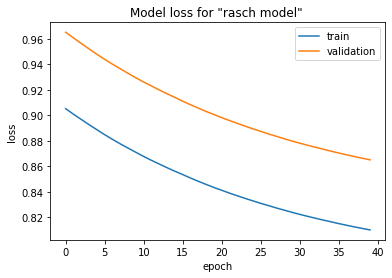

In [11]:
model1pl.plot()

* **Following are the available default configs(backend-distributions)**

In [12]:
model1pl.proxy_model.default_backend_dist_params

{'backend': {'keras': {'distrib': {'normal': {'mean': 0, 'stddev': 0},
    'uniform': {'minval': 0, 'maxval': 0, 'distrib': 'uniform'}}},
  'pytorch': {'distrib': {'normal': {'mean': 0, 'stddev': 0},
    'uniform': {'minval': 0, 'maxval': 0, 'distrib': 'uniform'}}}}}

* For existing configs, following is the updated dictionary(containing initializer objects as a result of `get_initializers()`) taking reference configs from `default_backend_dist_params` dictionary above.

In [13]:
model1pl.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel_params': {},
  'kernel': <keras.initializers.RandomNormal at 0x7f924dcfde10>},
 'diff_params': {'units': 1,
  'kernel_params': {},
  'kernel': <keras.initializers.RandomNormal at 0x7f924dcfde48>},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomNormal at 0x7f924dcfdeb8>},
 'guess_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f924dcfdef0>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'}}

* default kernel weights in 3rd layer via create_model() here are **initialized with keras/normal**

In [15]:
model1pl.model.layers[3].get_config()

{'name': 'latent_trait',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'RandomNormal',
  'config': {'mean': 0, 'stddev': 1, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': {'class_name': 'L1L2',
  'config': {'l1': 0.0, 'l2': 0.0}},
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

### Scheme 2. Changing some values and passing new vals to model params.

* Customizing some initializers for new training exp.
    * kernel_params of select layer of-- latent_trait, difficulty_level, disc_params, guess_params

* 1.1 Updating `ability_params` layer's kernel initilizer to `keras:uniform:defaults`

In [23]:
params_ = {'ability_params': {'units':1, 'kernel_params': {'distrib':'uniform'}}}
params_

{'ability_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}}}

In [24]:
model1pl= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [25]:
model1pl.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 1.549 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [26]:
#Overall model_params with kernel_params & kernels after updation 1.1
model1pl.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f57d86f4828>},
 'diff_params': {'units': 1,
  'kernel_params': {},
  'kernel': <keras.initializers.RandomNormal at 0x7f582fe23f60>},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomNormal at 0x7f582fe23fd0>},
 'guess_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f582fad6048>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'},
 'difficulty_level': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f5810323cf8>}}

In [27]:
model1pl.model.layers[3].get_config()#layer 3 corresponds to ability

{'name': 'latent_trait/ability',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': 0, 'maxval': 0, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': {'class_name': 'L1L2',
  'config': {'l1': 0.0, 'l2': 0.0}},
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

* 1.2 Updating `difficulty_level` layer's kernel initilizer to `keras:uniform:minval:-2`

In [28]:
model1pl.model.layers[4].get_config()#before updation

{'name': 'difficulty_level',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'RandomNormal',
  'config': {'mean': 0, 'stddev': 1, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [34]:
params_ = {'diff_params': {'units':1, 'kernel_params': {'distrib':'uniform', 'minval':-2}}}
params_

{'diff_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -2}}}

In [44]:
model1pl_2= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [45]:
model1pl_2.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 1.701 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [37]:
#layer 4 corresponds to difficulty
model1pl_2.model.layers[4].get_config()#After select kernel_param updation

{'name': 'difficulty_level',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -2, 'maxval': 0, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [38]:
#Overall model_params with kernel_params & kernels after updation 1.2
model1pl_2.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f57d86f4828>},
 'diff_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -2},
  'kernel': <keras.initializers.RandomUniform at 0x7f57c06b37b8>},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomNormal at 0x7f582fe23fd0>},
 'guess_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f582fad6048>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'},
 'difficulty_level': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f5810323cf8>},
 'diff_level': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval

* 1.3 Updating Multiple layer(All) initializer at once--
    *`latent_trait`->`keras:uniform:defaults`
    *`difficulty_level'`->`keras:uniform:defaults`
    *`'disc_params`->`keras:normal:stddev:0`
    *`guess_params`->`keras:normal:stddev:0`

In [46]:
params_ = {'ability_params': {'units': 1, 'kernel_params':{'distrib': 'uniform'}},
 'diff_params': {'units': 1,'kernel_params': {'distrib': 'uniform'}},
 'disc_params':{'units': 1, 'kernel_params': {'stddev': 0},'train': False,'act':'exponential'},
 'guess_params': {'units': 1, 'kernel_params': {'stddev': 0}, 'train': False, 'act': 'linear','slip': 0}}
params_

{'ability_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'linear',
  'slip': 0}}

In [47]:
model1pl_3= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [48]:
model1pl_2.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 1.744 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [49]:
model1pl_3.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f57d86f4828>},
 'diff_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -2},
  'kernel': <keras.initializers.RandomUniform at 0x7f57c06b37b8>},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomNormal at 0x7f582fe23fd0>},
 'guess_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'train': False,
  'act': 'linear',
  'slip': 0,
  'kernel': <keras.initializers.RandomUniform at 0x7f582fad6048>},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'},
 'difficulty_level': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f5810323cf8>},
 'diff_level': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval

* default kernel weights in 3rd layer via create_model() here are **initialized with keras/Uniform**

In [50]:
model1pl_2.model.layers[3].get_config()

{'name': 'latent_trait/ability',
 'trainable': True,
 'dtype': 'float32',
 'units': 1,
 'activation': 'linear',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': 0, 'maxval': 0, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': {'class_name': 'L1L2',
  'config': {'l1': 0.0, 'l2': 0.0}},
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

### Scheme 3. User bringing in all initializer objects nad passing corresponding object declarations to model_params.

* How to add new distribution

* 1.1 Customizing all layers' kernel in model_params through object declaration (Total scheme 3)

In [55]:
from keras import initializers

In [65]:
params_1 = {'ability_params': {'units': 1,'kernel':initializers.RandomNormal(mean=1, stddev=0.5)},
 'diff_params': {'units': 1,'kernel':initializers.RandomUniform(minval=-3.5, maxval=-2.5)},
 'disc_params':{'units': 1, 'kernel':initializers.RandomNormal(mean=0.5, stddev=1.5),'train': False,'act':'exponential'},
 'guess_params': {'units': 1, 'kernel':initializers.RandomUniform(minval=-3.5, maxval=-1.5), 'train': False, 'act': 'linear','slip': 0}}
params_1

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f577f07e0f0>},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f577f07e128>},
 'disc_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f577f07e160>,
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f577f07e198>,
  'train': False,
  'act': 'linear',
  'slip': 0}}

In [66]:
model1pl= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [67]:
model1pl.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_1)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 1.909 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [68]:
model1pl.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f577f07e0f0>},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f577f07e128>},
 'disc_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f577f07e160>,
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f577f07e198>,
  'train': False,
  'act': 'linear',
  'slip': 0},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'},
 'difficulty_level': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f5810323cf8>},
 'diff_level': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -2},
  'kernel': <keras.initializers.RandomUniform at 0x7f57d8280128>}}

* 1.1 Customizing some layers' kernel in model_params through object declaration and remaining through use of available defaults(a mix of scheme 2 & 3)

In [58]:
params_2 = {'ability_params': {'units': 1,'kernel':initializers.RandomNormal(mean=1, stddev=0.5)},
 'diff_params': {'units': 1,'kernel':initializers.RandomUniform(minval=-3.5, maxval=-2.5)},
 'disc_params':{'units': 1, 'kernel_params': {'distrib': 'uniform', 'minval':-6},'train': False,'act':'exponential'},
 'guess_params': {'units': 1, 'kernel':initializers.RandomUniform(minval=-3.5, maxval=-1.5), 'train': False, 'act': 'linear','slip': 0}}
params_2

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f577f0012b0>},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f577f0012e8>},
 'disc_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -6},
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f577f001320>,
  'train': False,
  'act': 'linear',
  'slip': 0}}

In [59]:
model1pl_2= dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [62]:
model1pl_2.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_2)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;

Training on : 3135 samples for : 40 epochs has completed in : 2.064 seconds.

Use object.plot() to view train/validation loss curves;
Use `object.history` to obtain train/validation loss across all the epochs.
Use `object.coefficients()` to obtain model parameters--difficulty, discrimination & guessing


In [64]:
#Overall model_params with kernel_params & kernels after updation 1.1
model1pl_2.proxy_model.get_params()

{'ability_params': {'units': 1,
  'kernel': <keras.initializers.RandomNormal at 0x7f577f0012b0>},
 'diff_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f577f0012e8>},
 'disc_params': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -6},
  'train': False,
  'act': 'exponential',
  'kernel': <keras.initializers.RandomUniform at 0x7f577f0067f0>},
 'guess_params': {'units': 1,
  'kernel': <keras.initializers.RandomUniform at 0x7f577f001320>,
  'train': False,
  'act': 'linear',
  'slip': 0},
 'regularizers': {'l1': 0, 'l2': 0},
 'hyper_params': {'units': 1,
  'optimizer': 'sgd',
  'loss': 'binary_crossentropy'},
 'difficulty_level': {'units': 1,
  'kernel_params': {'distrib': 'uniform'},
  'kernel': <keras.initializers.RandomUniform at 0x7f5810323cf8>},
 'diff_level': {'units': 1,
  'kernel_params': {'distrib': 'uniform', 'minval': -2},
  'kernel': <keras.initializers.RandomUniform at 0x7f57d8280128>}}

In [70]:
#layer 2 corresponds to discrimination
model1pl_2.model.layers[2].get_config()

{'name': 'disc_param',
 'trainable': False,
 'dtype': 'float32',
 'units': 1,
 'activation': 'exponential',
 'use_bias': False,
 'kernel_initializer': {'class_name': 'RandomUniform',
  'config': {'minval': -6, 'maxval': 0, 'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

* Easing updation of kernel params Or Kernel; ignoring the mention of other key:value pairs at same level of model_param dictionary during updation. (So to infer, preventing dictionary Overwrite).

For instance Enable working with-- params_ = `{'guess_params': {'kernel_params': {'distrib':'uniform', 'minval':-2}}}` NOT `'{guess_params':{'units':1, 'kernel_params':{'distrib':'uniform'}, 'train':False, 'act':'linear', 'slip':0}`

* 1.1

In [15]:
#standard model_params
params_ = {'ability_params': {'units': 1, 'kernel_params':{'distrib': 'uniform'}},
 'diff_params': {'units': 1,'kernel_params': {'distrib': 'uniform'}},
 'disc_params':{'units': 1, 'kernel_params': {'stddev': 0},'train': False,'act':'exponential'},
 'guess_params': {'units': 1, 'kernel_params': {'stddev': 0}, 'train': False, 'act': 'linear','slip': 0}}
params_

{'ability_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'linear',
  'slip': 0}}

In [16]:
#models to selectively update
params_1 = {'diff_params': {'kernel_params': {'distrib':8454, 'minval':-2}},
           'guess_params':{'units':56, 'slip':15}
           }
params_1

{'diff_params': {'kernel_params': {'distrib': 8454, 'minval': -2}},
 'guess_params': {'units': 56, 'slip': 15}}

* Without tap update

In [9]:
params_.update(params_1)
params_

{'ability_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'kernel_params': {'distrib': 8454, 'minval': -2}},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 56, 'slip': 15}}

* With Tap update

In [12]:
from dict_deep import *

def tap_update(params_to_tap, params):
        li= list()
        for k, v in params.items():
            n_keys= len(v.keys())
            for key, val in v.items():#for iters in range(n_keys):
                li= [k,key]# for key, val in v.items()
                deep_set(params_to_tap, li, deep_get(params, li), 
                    accessor=lambda params_to_tap, k: params_to_tap.setdefault(k, dict()))


In [13]:
tap_update(params_, params_1)
params_

{'ability_params': {'units': 1, 'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'units': 1, 'kernel_params': {'distrib': 8454, 'minval': -2}},
 'disc_params': {'units': 1,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'exponential'},
 'guess_params': {'units': 56,
  'kernel_params': {'stddev': 0},
  'train': False,
  'act': 'linear',
  'slip': 15}}

In [141]:
#d_keys= list()
#for i, k in enumerate(list(params_)):
#    d_keys.append([k]+ [key for key, val in params_[k].items() if isinstance(val, dict)])
#d_keys

[['ability_params', 'kernel_params'],
 ['diff_params', 'kernel_params'],
 ['disc_params', 'kernel_params'],
 ['guess_params', 'kernel_params']]

In [14]:
model1pl_4 = dope(primal1)

Transpiling your model to it's Deep Neural Network equivalent...


In [19]:
params_ = {'ability_params': {'kernel_params':{'distrib': 'uniform'}},
 'diff_params': {'kernel_params': {'distrib': 'uniform', 'minval':-3}}}
params_

{'ability_params': {'kernel_params': {'distrib': 'uniform'}},
 'diff_params': {'kernel_params': {'distrib': 'uniform', 'minval': -3}}}

In [20]:
model1pl_4.fit(x_user=x_train_user,x_questions=x_train_questions,
          y_vals=y_train, batch_size=64, epochs=40, params=params_)
#model1pl.proxy_model.update_params(params_) is triggered within


Intitializing fit for rasch model. . .
Batch_size: 64; epochs: 40;


KeyError: 'units'

* 1.2

In [ ]:
params_2 = {'diff_params': {'kernel': initializers.RandomUniform(minval=-2, maxval=-2.5)}}
params_2

________________________

* Following is nested config defaults

In [176]:
default_params= {}
backends_li= ['keras', 'pytorch']
dist_dict= {'normal':{'mean':0, 'stddev':1}, 'uniform':{'minval':0, 'maxval':0}}

for backend in backends_li:
    for dist, pars in dist_dict.items():
        deep_set(default_params, ['backend',backend,'distrib',dist],pars, 
                accessor=lambda default_params, k: default_params.setdefault(k, dict()))
default_params

{'backend': {'keras': {'distrib': {'normal': {'mean': 0, 'stddev': 1},
    'uniform': {'minval': 0, 'maxval': 0}}},
  'pytorch': {'distrib': {'normal': {'mean': 0, 'stddev': 1},
    'uniform': {'minval': 0, 'maxval': 0}}}}}